# Music classifier

By: Francesco Civilini

Last time, we delved into the theory of deep learning and stochastic gradient descent. This time, we are going to try a basic computer vision example and explain some new concepts as we go along. 

In this exercise, we will build a deep learning classifier to recognize whether the instrument in an input sound file is a piano, violin, or guitar. The classifier was built using the *fastai* library (https://docs.fast.ai/), which sits on *PyTorch*. This is a very general example that can easily be expanded to other music instruments. 

The main way that I tackled this problem is by converting each music piece to a **spectogram**, which displays the frequencies for the music with time, and then using the *fastai* computer vision algorithms to generalize what a spectogram for each instrument looks like.

The spectogram method is similar to what the *Shazam* music app does albeit much more generalized. The company has spectograms of thousands of music pieces provided by producers. When you use the app, it converts the audio into a spectogram and tries to match it to another spectogram in its database. We are doing something a bit different, as we are not interested in spectograms of particular songs but instead in the general trend of spectograms for certain categories.  

**NOTE:** I will not upload the music files to my *GitHub* due to copyright regulations. However, all the spectogram figures that were used to run the neural net will be provided.

# Background on image classification 

In the last post we introduced the basics behind neural nets and introduced weights, biases, and hidden layers. However, it may be unclear (rightfully so!) just how we go from those parameters to image recognition. 

We start from a single pixel idea discussed in the *fast.ai* Deep Learning Lesson 4 (https://course.fast.ai/videos/?lesson=4). In this example, we take a single pixel and pass it through three hidden layers to obtain an output. The objective is to recognize handwritten digits, exactly the same problem I first played around with last year when I first was introduced to deep learning (https://github.com/civilinifr/fc_deeplearning/blob/master/kaggle_kernels/fc_digit_recognizer_v1.ipynb). The class example can be described by the following illustration:

<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/instrument_png/3hid.png" alt="Drawing" style="width: 300px;">

which contains the input $x$, weights $w$, and hidden layers $h$. At first glance, this may seem the same as the examples we discussed in the previous post. However, a pixel (in our case labeled by $x$) is actually a vector composed of three elements corresponding to red, blue, and green values:

$\vec{x} = [x_r, x_b, x_g]$

Due to this, our weights $w$ now have to have particular dimensions. Continuing the example discussed in the class, we obtain the following structure:

<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/instrument_png/pixel_example.png" alt="Drawing" style="width: 500px;">

Ok, I know this might seem terrifying, but it's the same structure discribed by the first illustration. The complication is that our weights are now a matrix instead of a scalar value and the size of our matrix keeps changing. As before, the weight matrices are initially filled with random numbers and the @ sign decribes matrix multiplication. Our three hidden layers are two relu's ($h1$ and $h2$) and a sigmoid ($h3$). Eventually, after multiplication with a matrix of size [8x10], we end up with a size 10 vector which corresponds to probabilities for each of the possible ten digits. Then we do stochastic gradient descent (**SGD**) like in the line-fitting problem from last time and update the weights. Take the time to follow the matrix multiplication and verify the dimensions if you're a bit rusty on this kind of algebra. 

You might wonder how on earth this particular algorithm can discern anything from one pixel. You'd be right! This is just an extremely basic example showing the operations that would need to be applied to every single pixel. To do image recognition in this context would require a number of imputs (with dimensions 3 due to colors) equal to the total pixels of the image. This is a ghastly number of operations which would be completely unfeasable for large images. Fortunately, there's a better way!


Instead of creating a neural net which operates on a vector or matrix, we will instead be working with three-dimensional tensors (or a volume) and will require new methods and nomenclature for this problem. I found the reference of the Stanford class CS231 useful for understanding the problem (http://cs231n.github.io/convolutional-networks/). Let's take a look at this example: 

<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/instrument_png/volumetric.png" alt="Drawing" style="width: 500px;">


Our input layer is now an image of size [32x32x3], or 32 by 32 pixels each with RGB values. Our matrix multiplication is now a 3D tensor with a **kernel** or **filter** of size [3x3x3]. It functionally works the same way, but the size of the filter is much smaller than the size of the tensor. Therefore, we need to "slide" the filter across the entire volume of the input image. This is called a **convolution**. The size of the filter is referred to as the **receptive field** ($F$) and the amount that the filter is shifted for each iteration is called the **stride** ($S$). Often times the size of the filter will not divide evenly in the input volume. In this case, empty pixels ($P$) are added to the input image. This is called **zero-padding**. The length and width of the resulting tensor ($O$) can be determined by:

$O = (W - F + 2P)/S + 1 $

So where did the 12 dimensions of depth come from? Various kernels can bring out specific features in the data, so typically an image classifier will use many different kernels. In this example, we are using 12 different kernels. The results of the convolution for each of these 12 kernels are combined together and form the **convolution layer** (in our case, this layer is of size [30x30x12]). 

The next stage is a relu. This non-linear layer operates on the data in the same way as what we discussed in the previous section. The next operation is a **pool**, which simply downsizes the data. 

Now we need a loss function to minimize using SGD. *PyTorch*, which is the library we will use for this task, uses **cross-entropy** or log-loss, which measures the performance of a model where the prediction is a value between 0 and 1. For two classes, this is measured by:

$-y\log(\hat{y})-(1-y)\log(1-\hat{y}) $

where $y$ and $\hat{y}$ are the observed and predicted data. 

For multiple classes, the cross-entropy is defined as:

$- \sum_{C=1}^{M} y_{O,C} \log(P_{O,C})$

where $M$ is the total number of classes, $y_{O,C}$ is the binary indicator for a correct classication of class $C$ for observation $O$, and $P_{O,C}$ probability that the observation $O$ is of class $C$. 

# Plot an example of the music classes

But enough of the theory right now. Let's take a look at some data and what a spectogram for each of our three classes looks like.

First, import all of the libraries that we will need throughout this code. This exercise involves a bit of **feature engineering**, or data pre-processing unique to the problem we are trying to solve. To make our lives a little easier, we will use the *joblib* parallel library to run a few steps in parallel.  

In [1]:
from scipy.io import wavfile
from scipy import signal
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mpl
from joblib import Parallel, delayed
import glob
import os
from fastai.vision import *
from fastai.metrics import error_rate

Debugging is an important tool for any sort of programming. Although Jupyter Notebook is great in many respects, it cannot run a debugger natively. I find that the *pixiedust* debugger works quite well. It is imported like any other Python package and can be intialized by placing %%pixie_debugger at the beginning of a cell.    

In [24]:
# Import the debugger
import pixiedust
pixiedust.optOut()

Pixiedust database opened successfully


Pixiedust will not collect anonymous install statistics.


The function *plot_wave_spectro* plots the first 30 seconds of a waveform and the resulting spectogram. In order to be able to compare each spectogram, they needs to be standardized in both time and frequecy domains. 

**Time-domain standardization:** Since each song is of different lenghts, we need to pick fixed time period to standardize each spectogram. In this case, we chose the first 30 seconds of each piece.  

**Fourier-domain standardization:** From Fourier theory, we know that the energy in the frequency domain is proportional to the time-domain amplitude. In other words, sections where the music is loud will result in larger values in the spectogram. This is a problem for our classifer, as quiet and loud pieces of the same instrument may have drastically different spectograms. This may also greatly depend on how the piece itself was recorded. To solve this, we created a normalization function *norm* that averages out the input amplitude between 0 and 1.

We limit the spectogram y-axis to 12500 Hz. This value depends on the frequency range of the instrument. Remember, we are trying to bring out the difference between each instrument, so keep it consistent. 

The inputs of the spectogram function are the input data, sampling frequency (*input_fs*), maximum velocity (*input_vmax*) and song title (*input_title*). The maximum velocity parameter describes the color scaling of the spectogram, which is related to the energy density of each frequency. Because the seismogram was normalized between 0 and 1, this value is very small. 

In [2]:
path = '/media/francesco/Elements/ML_projects/music_recognizer/'

In [3]:
#%%pixie_debugger
# Normalized the input data between 0 and 1
def norm(input_data):
    
    x = np.array(input_data)
    y = x.astype(np.float)
    
    norm_data = []
    maxval = max(y)
    minval = min(y)
    
    for val in y:
        
        norm_data.append(float((val-minval)/(maxval-minval)))
        
    return norm_data

In [30]:
# Plot the first 30 seconds of the waveform (normalized) and the spectogram of the music
def plot_wave_spectro(input_data, input_fs, input_vmax, input_title):
    
    time_axis = np.arange(len(input_data))/input_fs
    f, t, Sxx = signal.spectrogram(np.array(input_data), input_fs)
    
    fig = plt.figure(figsize=(15,4))
    ax1=plt.subplot(1, 2, 1)
    plt.plot(time_axis,input_data)
    plt.xlim((0,30))
    plt.xlabel('Time (s)', fontweight='bold')
    plt.ylabel('Amplitude', fontweight='bold')
    plt.title(input_title, fontweight='bold')
    
    ax2=plt.subplot(1, 2, 2)
    plt.pcolormesh(t, f, Sxx, cmap=cm.jet, vmax=input_vmax)
    plt.ylabel('Frequency (Hz)', fontweight='bold')
    plt.xlabel('Time (sec)', fontweight='bold')
    plt.xlim((0,30))
    plt.ylim((0,12500))
    plt.colorbar()
    
    fig.tight_layout()

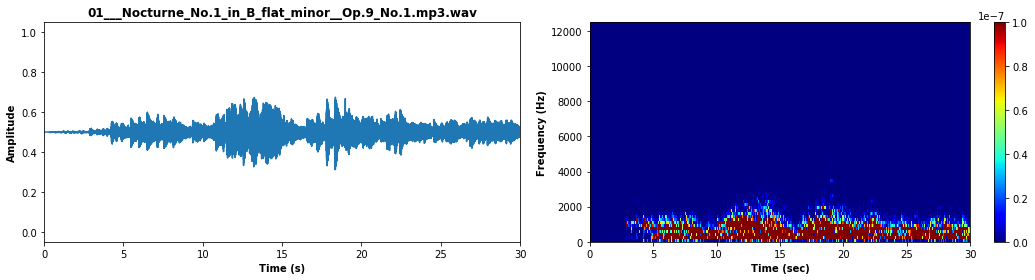

In [31]:
# Plot the waveform and spectogram of the first 30 seconds of a piano piece
input_music = f'{path}piano_wav/01___Nocturne_No.1_in_B_flat_minor__Op.9_No.1.mp3.wav'
fs, data = wavfile.read(input_music)
data_normalized = norm(data)
plot_wave_spectro(data_normalized, fs, 0.0000001, input_music.split('/')[-1])

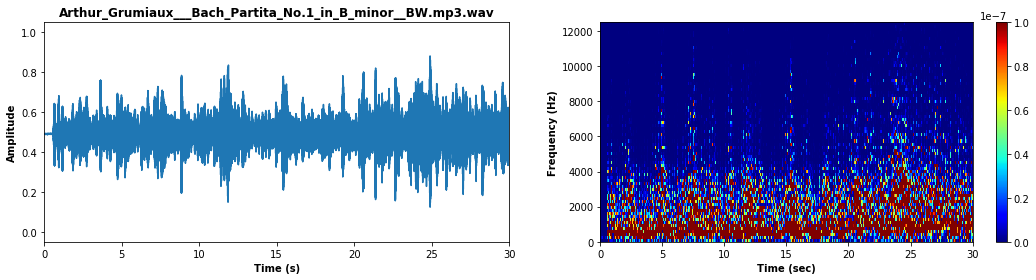

In [32]:
# Now let's take a look at a violin piece 
input_music = f'{path}violin_wav/Arthur_Grumiaux___Bach_Partita_No.1_in_B_minor__BW.mp3.wav'
fs, data = wavfile.read(input_music)
data_normalized = norm(data)
plot_wave_spectro(data_normalized, fs, 0.0000001, input_music.split('/')[-1])

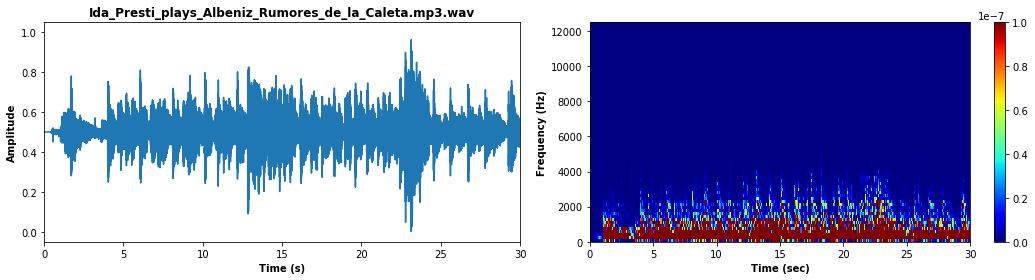

In [33]:
# And finally guitar music
input_music = f'{path}guitar_wav/Ida_Presti_plays_Albeniz_Rumores_de_la_Caleta.mp3.wav'
fs, data = wavfile.read(input_music)
data_normalized = norm(data)
plot_wave_spectro(data_normalized, fs, 0.0000001, input_music.split('/')[-1])

From above, we can see that the violin has the highest frequencies and piano has the lowest frequencies. The guitar and piano have similar frequencies, but the guitar is much more impulsive in time. 

# Data pre-processing

As you may have spotted from the previous section, our input data needs to be in .wav format in order for *SciPy* to read in the data. I started with directories of approximately 100 music pieces for each instrument type in .mp3 format and needed to convert them to .wav. There are many ways to do so, but I used the *ffmpeg* library as suggested by user Wernight in this post:
https://stackoverflow.com/questions/9458480/read-mp3-in-python-3

Music filenames will typically not be formatted well, and may include spaces or extra characters. 

Run the following Perl script from user Dennis Williamson in your directory (https://stackoverflow.com/questions/2709458/how-to-replace-spaces-in-file-names-using-a-bash-script) to remove spaces:

find -name "* *" -type f | rename 's/ /_/g'

Do the same with this Perl script from LRI (https://apple.stackexchange.com/questions/93322/how-to-strip-a-filename-of-special-characters) to remove any special characters in the filename:

for f in *; do mv "$f" "$(sed 's/[^0-9A-Za-z_.]/_/g' <<< "$f")"; done

We then convert to .wav by calling the ffmpeg Linux function from inside Python (done using ! at the beginning of the line). 

In [4]:
# Convert a file from .mp3 to .wav
def convert_mp3_wav(input_file, input_folder, output_folder):
    
    filename = input_file.split('/')[-1]
    
    if not os.path.exists(f'{output_folder}{filename}.wav'):
        ! ffmpeg -i {input_folder}{filename} -vn -acodec pcm_s16le -ac 1 -ar 44100 -f wav {output_folder}{filename}.wav
        print(f'Saved file {filename}.wav ...')
        
    else:    
        print(f'Skipping file {filename}...')
        
    return

In [6]:
# We write down the following capture line so Jupyter doesn't spam the output. 
%%capture

# Convert the violin music to .wav from .mp3
classes = ['piano', 'violin', 'guitar']

for instrument in classes:
    
    mp3_folder = f'/media/francesco/Elements/ML_projects/music_recognizer/{instrument}_mp3/'
    wav_folder = f'/media/francesco/Elements/ML_projects/music_recognizer/{instrument}_wav/'

    filelist = glob.glob(f'{mp3_folder}*.mp3')

    for file in filelist:
        
        convert_mp3_wav(file, mp3_folder, wav_folder)

We are now ready to save the spectogram for each piece of music! Similar to our previous example, we will use the first 30 seconds of the music. We also use the Parallel library to speed this process up a little bit. In this example I use 7 cores. 

The spectograms are saved into a "runs" folder labeled corresponding to the used time segment.

In [7]:
def save_spectogram(input_file, output_folder):
    
    wavfile_name = input_file.split('/')[-1]
    
    fs, data = wavfile.read(input_file)
    data_normalized = norm(data)
    
    time_axis = np.arange(len(data_normalized))/fs
    f, t, Sxx = signal.spectrogram(np.array(data_normalized), fs)
    input_vmax = 0.0000001
    
    mpl.rcParams['savefig.pad_inches'] = 0
    plt.pcolormesh(t, f, Sxx, cmap=cm.jet, vmax=input_vmax)
    plt.xlim((0,30))
    plt.ylim((0,12500))
    plt.axis('off')
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    plt.autoscale(tight=True)
    
    plt.savefig(f'{output_folder}{wavfile_name}.png')
    print(f'Saved file {wavfile_name}.png ...')
    plt.close()
    

In [10]:
%%capture

classes = ['piano', 'violin', 'guitar']

# Create a runs folder with a title descriptive of the time segment used
runs_folder = f'{path}runs/'
testnum = 'run1_0_30s'

for instrument in classes:

    wav_folder = f'{path}{instrument}_wav/'
    spectogram_folder = f'{runs_folder}{testnum}/{instrument}/'
    
    # Create a directory for the output in case it doesn't exist
    if not os.path.exists(spectogram_folder):
        os.makedirs(spectogram_folder)

    wav_tracks = glob.glob(f'{wav_folder}*.wav')

    num_cores = 7
    Parallel(n_jobs=num_cores)(delayed(save_spectogram)(wav_track, spectogram_folder) for wav_track in wav_tracks)


# Create a Neural Net

Now we can finally get away from the pre-processing and create a classifier! As previously mentioned, we will use the tools provided by the *fastai* computer vision library. The code itself is only a few lines, so we will go in-depth into what each parameter and greater concept mean. 

In [88]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
# Set the input folder path
runs_folder = f'{path}/runs/'
testnum = 'run1_0_30s'
nn_path =  f'{runs_folder}{testnum}'

In [18]:
# Create a databunch
data = ImageDataBunch.from_folder(nn_path, train=".", bs=16, valid_pct=0.2,
                                  size=224).normalize(imagenet_stats)

We need to load all of the data for the algorithm. The class *ImageDataBunch* creates an object that can be customized to fit many different types of data structures. We use the method *from_folder* because the images of our classes are separeted by folder names. 

Deep Learning algorithms typically require the data to be separated into two sets: a training set and a validation set. 

A **training set** contains the images in which the algorithm will use to generalize an image. The **validation set** contains the images in which the produced model will be tested. It is not possible to accurately understand the accuracy of a produced model without having a validation set that independent of the training set. 

The accuracy of both the training and validation sets should be tracked as it contains important descriptive information regarding errors in the models. For example, high accuracy in the training set but low accuracy in the validation set describes **overfitting** (i.e., model is not general enough). Conversely, greater accuracy in the validation set compared to the trainig set might mean that the model is too general (**underfitting**). 

The parameter *train* equals the current folder (i.e. the "." as per Unix convention), which is where the spectogram folders are:

In [17]:
! ls {nn_path}

guitar	piano  violin


So what about the validation set? After all, we only have one folder for each class. The parameter *valid_pct* is used to split the data for each class into separate validation sets that will not be used. The value of 0.2 means that 20% of the input data will be isolated for the validation set (since we have approximately 100 images for each class that means about 20 images).   

The *bs* paramter corresponds to the **batch size**, or how many images are being loaded in the GPU at once. Depending on how much RAM your GPU has, you may want to change this number. 300 images is a fairly tiny dataset, so our batch size doesn't really matter in terms of computation speed. 

The *size* parameter corresponds to the pixel size of each image. This is an important parameter if your dataset has figures of varying sizes. Since we created the images of this dataset by ourselves, this is not very important. 

Lastly, the *normalize* method changes pixel sizes based on the mean and standard deviation. 

We can take a look that it imported the data correctly by using the function *show_batch*:

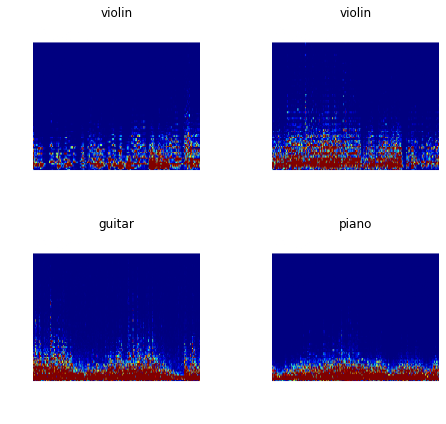

In [13]:
data.show_batch(rows=2, figsize=(7,6))

We will now create a neural network based on our input data and an initial model. However, we don't want to start off with a blank model if we don't have to. After all, can we confidently say that we can train a model from scratch that can recognize many different features using only 100 inputs? Probably not. 

Fortunately we don't have to! We can use pretrained models done by other people. In this case, I used the *ResNet* 34 layer model, which was trained on the image dataset *ImageNet*. *ImageNet* contains over 14 million images with 21 thousand labels, and *ResNet* only has a 3.37% error, so it's a good place to start. 

Further details on resnet34 can be found here: 
https://www.kaggle.com/pytorch/resnet34

In [23]:
# Let's create a neural net using a background of resnet 34. 
learn = create_cnn(data, models.resnet34, metrics=accuracy)

The **learning rate** is an important parameter that we briefly discussed in the last post. Essentially, it describes the rate at which we step through the loss function space per iteration of SGD. It was described by the last picture in the line-fitting post, which showed the travel of the loss through the mean squared error for each of the 100 iterations. But how do we know what sort of learning rate we want for the cross-entropy calculation for this data set? Fortunately, *fast.ai* has a handy function called "lr_find" which assesses the loss for different types of learning rates. 

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


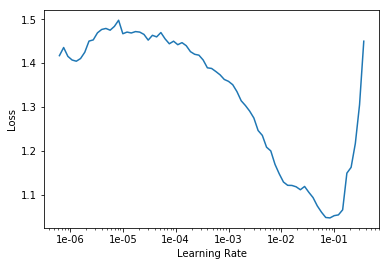

In [25]:
learn.recorder.plot()

We are looking for a learning rate that is small enough to find the global minimum of the loss function but not so small that it takes many iterations to find it or that it gets stuck in a local minimum. Based on the above plot, I'm going to choose 1e-2. 

In [28]:
# Now let's do 5 cycles of SGD on the data. 
learn.fit_one_cycle(5, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.956867,1.117347,0.596774
2,0.819558,1.320204,0.532258
3,0.717639,0.605690,0.838710
4,0.573350,0.561839,0.822581
5,0.449809,0.439188,0.887097


88% isn't bad! Now let's take take a look at some of the results. Particularily, we are interested in the ones that we got wrong. 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

#len(data.valid_ds)==len(losses)==len(idxs)

A side note before we keep going and interpreting the results. Fastai doesn't show titles when plotting top losses, but we can see the path of the images using the code snippet below. I show the filenames for the two worst results below. 

In [30]:
# Filenames for the worst two results
losses,idxs = interp.top_losses(2)
for p in data.valid_ds.x.items[idxs]:
    print(p)

/media/francesco/Elements/ML_projects/music_recognizer/runs/run1_0_30s/guitar/II._Cataluña__I._Albeniz_.mp3.wav.png
/media/francesco/Elements/ML_projects/music_recognizer/runs/run1_0_30s/piano/Horowitz_plays_Rachmaninoff_piano_sonata_no2_in_B___2_.mp3.wav.png


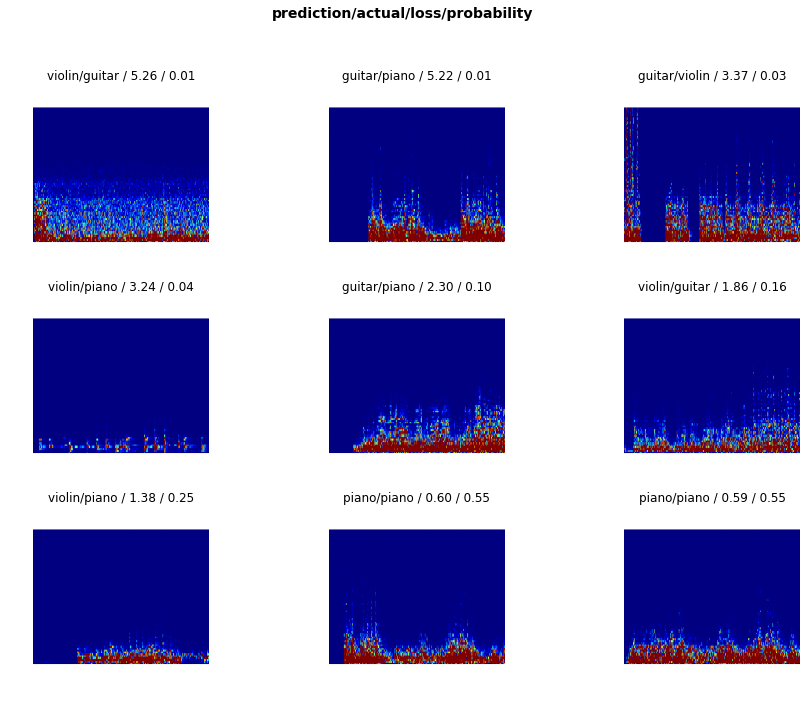

In [31]:
# Plot the worst 9 predictions (most wrong)
interp.plot_top_losses(9, figsize=(15,11))

In addition to the 7 total files that we got wrong, we can see that two of the piano files (number 8 and 9) were correct but the code was only 55% sure that it had gotten those results right. We can get a more comprehensive look at the errors using the function "plot_confusion_matrix":

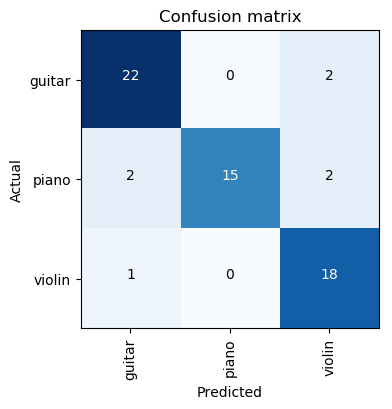

In [32]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=100)

# Make your own data augmentation 

88% isn't bad, but we can do better. A typical way that we can improve this number is to simply add more data. However, adding more music files is a lot of work, and doing feature engineering is kind of boring. What we can do to improve our results is **data augmentation**, which means creating more data from the data we already have. For image-recognition, this is typically done by cropping various parts of the picture of flipping the pictures across the vertical or horizontal. *Fastai* has these types of data augmentation that can be used in the "create_cnn" function.  Although this type of data augmentation might make sense if you're looking at pictures of objects, our spectograms would lose meaning if we changed orientation or started cropping. 

We are going to try what I call the "geophysicist approach" to coding, which is just trying to make it the code work for ourselves in a practical (albeit ungraceful) way. What we will do is go back to our .wav to spectogram routine and change it to produce spectogram every 30 seconds. The code parallelization will also need to be changed slightly so we don't get segmentation errors while trying to plot.

In [85]:
def plot_iteration(iteration, output_folder, wavfile_name, f, t, Sxx, input_vmax):
    
    min_x = 30*iteration
    max_x = 30*(iteration+1)

    mpl.rcParams['savefig.pad_inches'] = 0
    plt.pcolormesh(t, f, Sxx, cmap=cm.jet, vmax=input_vmax)
    plt.xlim((min_x,max_x))
    plt.ylim((0,12500))
    plt.axis('off')
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    plt.autoscale(tight=True)

    plt.savefig(f'{output_folder}{wavfile_name}_{min_x}_{max_x}.png')
    print(f'Saved file {wavfile_name}_{min_x}_{max_x}.png ...')
    plt.close()

    return

In [86]:
def save_spectogram_var(input_file, output_folder):
    
    wavfile_name = input_file.split('/')[-1]
    if len(glob.glob(f'{output_folder}{wavfile_name}*.png')) == 0:
        
        fs, data = wavfile.read(input_file)
        data_normalized = norm(data)

        time_axis = np.arange(len(data_normalized))/fs
        f, t, Sxx = signal.spectrogram(np.array(data_normalized), fs)
        input_vmax = 0.0000001

        # New iteration code - Every 30 seconds
        iteration_lim = np.floor(np.max(time_axis)/30) 
        iterations = np.arange(iteration_lim)
        
        
        num_cores = 5
        Parallel(n_jobs=num_cores)(delayed(plot_iteration)(iteration, output_folder, wavfile_name, f, t, Sxx, input_vmax))
        
    else:    
        print(f'Skipping file {wavfile_name}.png...')
    
    return

In [87]:
%%capture

classes = ['piano', 'violin', 'guitar']

# Create a runs folder with a title descriptive of the time segment used
runs_folder = f'{path}runs/'
testnum = 'run2_var'

for instrument in classes:

    wav_folder = f'{path}{instrument}_wav/'
    spectogram_folder = f'{runs_folder}{testnum}/{instrument}/'
    
    # Create a directory for the output in case it doesn't exist
    if not os.path.exists(spectogram_folder):
        os.makedirs(spectogram_folder)

    wav_tracks = glob.glob(f'{wav_folder}*.wav')
    
    for wav_track in wav_tracks:
        save_spectogram_var(wav_track, spectogram_folder)
    

We've grown the database from 100 entries to almost a thousand for each class! Now let's see if the models give greater accuracy!

In [95]:
# Set the input folder path
runs_folder = f'{path}/runs/'
testnum = 'run2_var'
nn_path =  f'{runs_folder}{testnum}'

In [96]:
# Create a databunch
data = ImageDataBunch.from_folder(nn_path, train=".", bs=16, valid_pct=0.2,
                                  size=224).normalize(imagenet_stats)

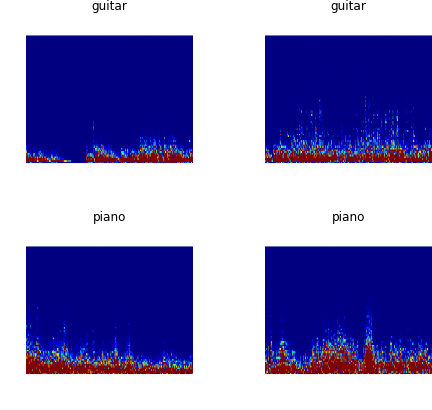

In [97]:
data.show_batch(rows=2, figsize=(7,6))

In [98]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [99]:
# Now let's do 5 cycles of SGD on the data again. 
learn.fit_one_cycle(5, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.578271,0.466293,0.838041
2,0.423454,0.285095,0.888889
3,0.309950,0.189478,0.917138
4,0.189199,0.203749,0.915254
5,0.110227,0.082387,0.975518


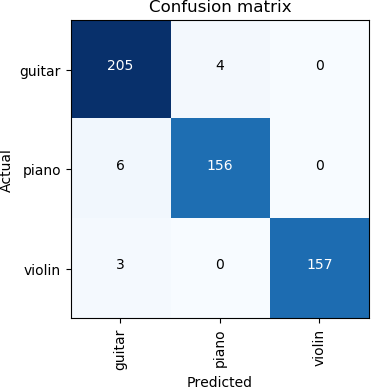

In [101]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=100)

We have now gone from a 88% accuracy to almost 98% simply by doing this rough data augmentation technique! Hopefully this helps you understand a bit more about how to do some simple image recognition. Thanks for taking a read and good luck!